In [1]:
import pandas as pd
import pandas_profiling

In [2]:
train = pd.read_csv("../data/tabular_playground/train.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
# train.profile_report()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

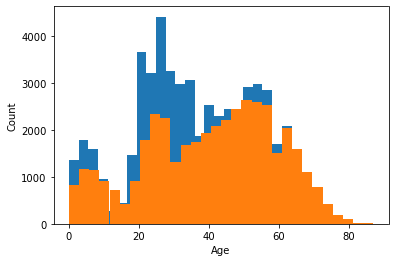

In [6]:
plt.hist(train.loc[train["Survived"] == 0, "Age"].dropna(), bins=30, label="0")
plt.hist(train.loc[train["Survived"] == 1, "Age"].dropna(), bins=30, label="1")

plt.xlabel("Age")
plt.ylabel("Count")

plt.show()

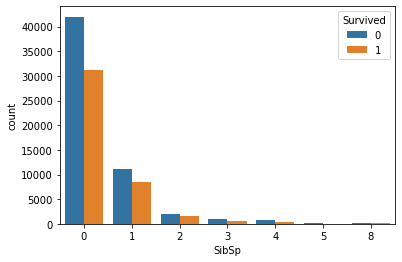

In [7]:
sns.countplot(x="SibSp", hue="Survived", data=train)
plt.legend(loc="upper right", title="Survived")
plt.show()

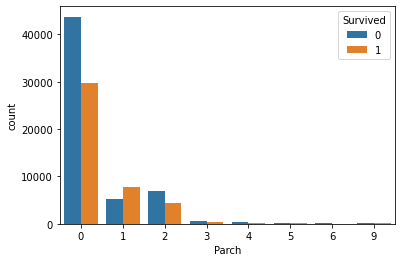

In [8]:
sns.countplot(x="Parch", hue="Survived", data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

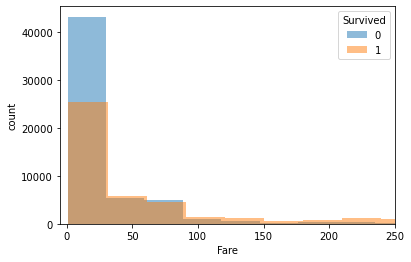

In [9]:
plt.hist(train.loc[train["Survived"] == 0, "Fare"].dropna(), bins=25, alpha=0.5, label="0")
plt.hist(train.loc[train["Survived"] == 1, "Fare"].dropna(), bins=25, alpha=0.5, label="1")

plt.xlabel("Fare")
plt.ylabel("count")
plt.legend(title="Survived")

plt.xlim(-5, 250)
plt.show()

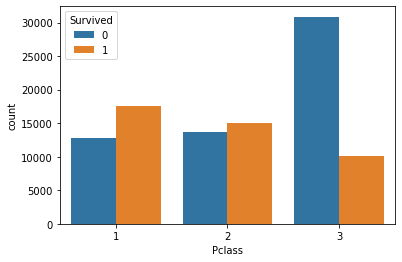

In [10]:
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.show()

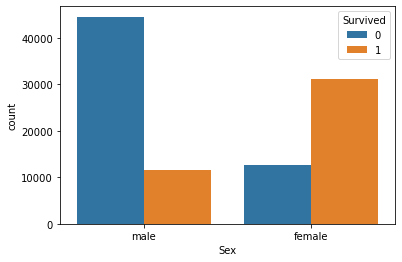

In [11]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.show()

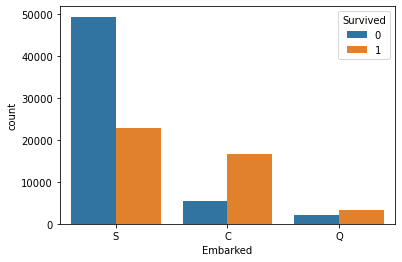

In [12]:
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.show()

## 考察
- あんまり元のtitanicと変わらなさそう？
- 同じ特徴量、モデルである程度まで行けそう

In [14]:
# 家族人数を考える
train["FamilySize"] = train["Parch"] + train["SibSp"] + 1


<AxesSubplot:xlabel='FamilySize', ylabel='count'>

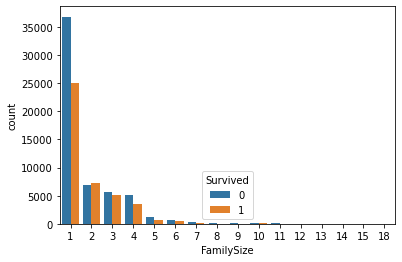

In [15]:
sns.countplot(x="FamilySize", data=train, hue="Survived")

In [16]:
# 一人かどうかも有効そう
train["IsAlone"] = 0
train.loc[train["FamilySize"] == 1, "IsAlone"] = 1

<AxesSubplot:xlabel='IsAlone', ylabel='count'>

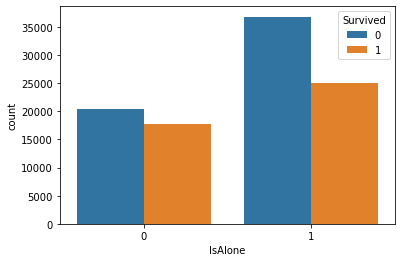

In [17]:
sns.countplot(x="IsAlone", data=train, hue="Survived")